Notes from Fandango, Armando. Mastering TensorFlow 1.x: Advanced machine learning and deep learning concepts using TensorFlow 1.x and Keras (Kindle Locations 2674-2676). Packt Publishing. Kindle Edition. 

# RNN in TensorFlow - TimeSeries Data <a class="tocSkip">

In [1]:
import math
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import sklearn as sk
from sklearn import preprocessing as skpp
print("sklearn:{}".format(sk.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20,
                     'figure.figsize': [15,10] 
                    })
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

NumPy:1.14.5
Pandas:0.22.0
sklearn:0.19.1
Matplotlib:2.2.2
TensorFlow:1.11.0


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# Read and pre-process the dataset

In [3]:
#filepath = os.path.join(datasetslib.datasets_root,
#                        'ts-data',
#                        'international-airline-passengers-cleaned.csv'
#                       ) 

filepath = '../data/international-airline-passengers.csv'
dataframe = pd.read_csv(filepath,
                        usecols=[1],
                        header=0)
dataset = dataframe.values
dataset = dataset.astype(np.float32)

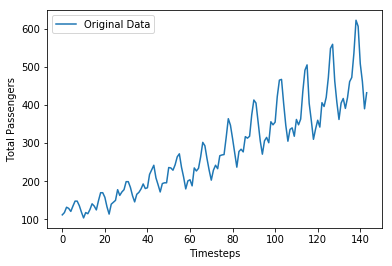

In [4]:
plt.plot(dataset,label='Original Data')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

In [5]:
# normalize the dataset
scaler = skpp.MinMaxScaler(feature_range=(0, 1))


In [6]:
dataset.shape

(145, 1)

In [7]:
dataset=dataset[:-1]

In [8]:
dataset.shape

(144, 1)

In order to make it ready for the learning models, normalize the dataset by applying MinMax scaling that brings the dataset values between 0 and 1. You can try applying different scaling methods to the data depending on the nature of your data.


In [9]:
normalized_dataset = scaler.fit_transform(dataset)

In [10]:
# split into train and test sets
# The data has to be split into training and test sets without shuffling the dataset 
#as shuffling the dataset breaks the sequence. 
#Maintaining the sequence of the data is important to train the time series models.

train,test=dsu.train_test_split(normalized_dataset,train_size=0.67)

* Set the number of past timesteps that are used to learn or predict the next timestep: n_x = 1 

* Set the number of future time steps to learn or predict: n_y = 1 

* Set the number of x variables that are used to learn; as the current example is univariate, this is set to 1: n_x_vars = 1 

* Set the number of y variables that are to be predicted; as the current example is univariate, this is set to 1: n_y_vars = 1


In [11]:
# convert into supervised learning set of input data and label
# Goal predict the time seties x_t from x_{t-1}

n_x=1
n_y=1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=n_y)

In [12]:
n_x_vars = 1  # number of x variables
n_y_vars = 1  # number of y variables

# TensorFlow SimpleRNN for TimeSeries Data

In [13]:
state_size = 4
n_epochs = 100
n_timesteps = n_x   # number of time steps
learning_rate = 0.1

In [14]:
tf.reset_default_graph()

Define the placeholders for X and Y parameters for the model. 

The shape of X placeholder is (batch_size, number_of_input_timesteps, number_of_inputs) 

and the shape of Y placeholder is (batch_size, number_of_output_timesteps, number_of_outputs). 

For batch_size, we use None so that we can input the batch of any size later.


In [15]:
X_p = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='X_p') 
# (batch_size, n_steps, n_input)
# n_steps tensors list of shape (batch_size, n_input)
Y_p = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='Y_p')

In [16]:
#Transform the input placeholder X_p into a list of tensors of length equal to the number of time steps, 
#which is n_x or 1 in this example:

# make a list of tensors of length n_x
rnn_inputs = tf.unstack(X_p,axis=1)

TensorFlow provides the static_rnn and dynamic_rnn convenience methods (among others) to create a static and dynamic RNN respectively.

The static_rnn method takes the following parameters: 

* cell:  The basic RNN cell object or another kind of cell. 

* rnn_inputs: The list of Tensors of shape (batch_size, number_of_inputs). 

* dtype: The data type of initial state and expected outputs.


Create a static RNN:

In [17]:
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
#Static RNN creates the cells, i.e. unrolls the loop, at the compile time. Dynamic RNN creates the cells, 
#namely unrolls the loop, at the runtime.

rnn_outputs, final_state = tf.nn.static_rnn(cell, 
                                            rnn_inputs,
                                            dtype=tf.float32
                                           )

In [18]:
#Define the weight and bias parameters for the predictions layer:

W = tf.get_variable('W', [state_size, n_y_vars])
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

In [19]:
#Define the predictions layer as a dense linear layer:

predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
print(predictions)

[<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>]


In [20]:
#The output Y is in the shape of Tensors; convert it to a list of tensors:
   
y_as_list = tf.unstack(Y_p, num=n_timesteps, axis=1)
print(y_as_list)

[<tf.Tensor 'unstack_1:0' shape=(?, 1) dtype=float32>]


In [21]:
mse = tf.losses.mean_squared_error

In [22]:
losses = [mse(labels=label, predictions=prediction) 
          for prediction, label in zip(predictions, y_as_list)
         ]


In [23]:
# Define the total loss as the average of losses of all the predicted time steps:

total_loss = tf.reduce_mean(losses)

In [24]:
#Define the optimizer to minimize the total_loss:

optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [25]:
# training
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    epoch_loss = 0.0
    for epoch in range(n_epochs):
        feed_dict={X_p: X_train.reshape(-1, n_timesteps, 
                                        n_x_vars), 
                   Y_p: Y_train.reshape(-1, n_timesteps, 
                                        n_x_vars)
                  }
        epoch_loss,y_train_pred,_=tfs.run([total_loss,predictions,optimizer], 
                                            feed_dict=feed_dict
                                           )
    print("train mse = {}".format(epoch_loss))
    feed_dict={X_p: X_test.reshape(-1, n_timesteps, 
                                    n_x_vars), 
               Y_p: Y_test.reshape(-1, n_timesteps, 
                                    n_y_vars)
              }
    test_loss, y_test_pred = tfs.run([total_loss,predictions], 
                                     feed_dict=feed_dict
                                    )
    print('test mse = {}'.format(test_loss))
    print('test rmse = {}'.format(math.sqrt(test_loss)))

train mse = 0.0026714333798736334
test mse = 0.02208944782614708
test rmse = 0.14862519243434835


In [26]:
y_train_pred=y_train_pred[0]
y_test_pred=y_test_pred[0]

In [27]:
#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

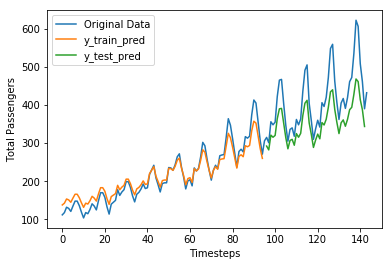

In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :] = y_test_pred
# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# TensorFlow LSTM for TimeSeries Data

train mse = 0.001958257984369993
test mse = 0.010100001469254494
test rmse = 0.10049876352102295


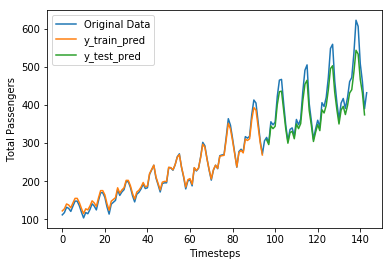

In [29]:
n_epochs = 600
n_timesteps = n_x   # number of time steps
n_x_vars = 1  # number of x variables
n_y_vars = 1  # number of y variables
learning_rate = 0.1

tf.reset_default_graph()
X_p = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='X_p') 
Y_p = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='Y_p')

# make a list of tensors of length n_x
rnn_inputs = tf.unstack(X_p,axis=1)

cell = tf.nn.rnn_cell.LSTMCell(state_size)
rnn_outputs, final_state = tf.nn.static_rnn(cell, rnn_inputs,dtype=tf.float32)

W = tf.get_variable('W', [state_size, n_y_vars])
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

y_as_list = tf.unstack(Y_p, num=n_timesteps, axis=1)

mse = tf.losses.mean_squared_error
losses = [mse(labels=label, predictions=prediction) for 
          prediction, label in zip(predictions, y_as_list)
         ]
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    epoch_loss = 0.0
    for epoch in range(n_epochs):
        feed_dict={X_p: X_train.reshape(-1, n_timesteps, 
                                        n_x_vars), 
                   Y_p: Y_train.reshape(-1, n_timesteps, 
                                        n_x_vars)
                  }
        epoch_loss,y_train_pred,_=tfs.run([total_loss,
                                           predictions,
                                           optimizer], 
                                          feed_dict=feed_dict
                                         )
    print("train mse = {}".format(epoch_loss))
    feed_dict={X_p: X_test.reshape(-1, n_timesteps, 
                                    n_x_vars), 
               Y_p: Y_test.reshape(-1, n_timesteps, 
                                    n_y_vars)
              }
    test_loss, y_test_pred = tfs.run([total_loss,predictions], 
                                feed_dict=feed_dict)
    
    print('test mse = {}'.format(test_loss))
    print('test rmse = {}'.format(math.sqrt(test_loss)))

y_train_pred=y_train_pred[0]
y_test_pred=y_test_pred[0]

#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :]=y_test_pred
# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# TensorFlow GRU for TimeSeries Data

train mse = 0.001954400911927223
test mse = 0.010653316974639893
test rmse = 0.1032149067462636


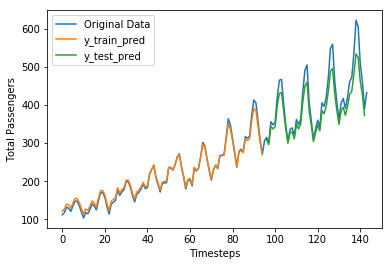

In [30]:
state_size = 4
n_epochs = 600
n_timesteps = n_x   # number of time steps
n_x_vars = 1  # number of x variables
n_y_vars = 1  # number of y variables
learning_rate = 0.1

tf.reset_default_graph()
X_p = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='X_p') 
Y_p = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='Y_p')

# make a list of tensors of length n_x
rnn_inputs = tf.unstack(X_p,axis=1)

cell = tf.nn.rnn_cell.GRUCell(state_size)
rnn_outputs, final_state = tf.nn.static_rnn(cell, rnn_inputs,dtype=tf.float32)

W = tf.get_variable('W', [state_size, n_y_vars])
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

y_as_list = tf.unstack(Y_p, num=n_timesteps, axis=1)

mse = tf.losses.mean_squared_error
losses = [mse(labels=label, predictions=prediction) for 
          prediction, label in zip(predictions, y_as_list)
         ]
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    epoch_loss = 0.0
    for epoch in range(n_epochs):
        feed_dict={X_p: X_train.reshape(-1, 
                               n_timesteps,
                               n_x_vars
                              ),
                   Y_p: Y_train.reshape(-1, 
                               n_timesteps,
                               n_y_vars
                              )
                  }
        epoch_loss,y_train_pred,_ = tfs.run([total_loss,
                                             predictions,
                                             optimizer], 
                                            feed_dict=feed_dict
                                           )
    print("train mse = {}".format(epoch_loss))
    feed_dict={X_p: X_test.reshape(-1, 
                                   n_timesteps,
                                   n_x_vars
                                  ),
               Y_p: Y_test.reshape(-1, 
                                   n_timesteps,
                                   n_y_vars
                                  )
              }
    test_loss, y_test_pred = tfs.run([total_loss,predictions], 
                                feed_dict=feed_dict)
    
    print('test mse = {}'.format(test_loss))
    print('test rmse = {}'.format(math.sqrt(test_loss)))

y_train_pred=y_train_pred[0]
y_test_pred=y_test_pred[0]

#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :]=y_test_pred
# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()